In [17]:
%pip install yfinance 
%pip install duckdb
%pip install pandas 
import yfinance as yf
import duckdb
import pandas as pd
from datetime import datetime, timedelta, timezone



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### What the following code block is doing:

we use the `isinstance` function to say is our df multiindexed if it is then do the following:

- for each ticker we want to remove all whitespace with `.strip()` then if our ticker is included within the `columns.levels[0]`  reset the index for that ticker and change columns to lower case, add this to our array called `frames`

In [18]:
def fetch_prices(tickers, period_days):
    # Fetch daily adjusted OHLCV for the last N days
    start = (datetime.now(timezone.utc) - timedelta(days=period_days)).date().isoformat()
    # .strip() to handle any extra spaces in ticker list
    df = yf.download(
        tickers=[t.strip() for t in tickers],
        start=start,
        interval="1d",
        group_by="ticker",
        threads=True,
        progress=False,
    )
    # Normalize to long format: date, ticker, open, high, low, close, volume
    frames = []
    if isinstance(df.columns, pd.MultiIndex):
        for t in tickers:
            if t.strip() not in df.columns.levels[0]:
                continue
            sub = df[t.strip()].reset_index()
            sub = sub.rename(columns=lambda x: x.lower())
            sub["ticker"] = t.strip()
            frames.append(sub)
    else:
        # Single ticker returns flat columns
        sub = df.reset_index()
        sub = sub.rename(columns=lambda x: x.lower())
        sub["ticker"] = tickers[0].strip()
        frames.append(sub)
    if not frames:
        return pd.DataFrame()
    out = pd.concat(frames, ignore_index=True)
    out = out.rename(columns={"index": "date"})
    out = out.dropna(subset=["close"])
    out["date"] = pd.to_datetime(out["date"]).dt.tz_localize("UTC").dt.date
    cols = ["date", "ticker", "open", "high", "low", "close", "volume"]
    return out[cols].sort_values(["ticker", "date"])

In [19]:
df = fetch_prices(
    tickers=["AAPL", "GOOGL", "MSFT"],
    period_days=30)
df

/var/folders/l3/07r79w4x3znd84b94h4223m80000gn/T/ipykernel_31908/1124278083.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Price,date,ticker,open,high,low,close,volume
0,2025-07-18,AAPL,210.630951,211.549907,209.462280,210.940598,48974600
1,2025-07-21,AAPL,211.859562,215.535383,211.390093,212.239120,51377400
2,2025-07-22,AAPL,212.898386,214.706331,211.989414,214.156952,46404100
3,2025-07-23,AAPL,214.756269,214.906093,212.169209,213.907227,46989300
4,2025-07-24,AAPL,213.657510,215.445490,213.287935,213.517670,46022600
...,...,...,...,...,...,...,...
58,2025-08-11,MSFT,522.299988,527.590027,519.719971,521.770020,20194400
59,2025-08-12,MSFT,523.750000,530.979980,522.700012,529.239990,18667000
60,2025-08-13,MSFT,532.109985,532.700012,519.369995,520.580017,19619200
61,2025-08-14,MSFT,522.559998,525.950012,520.140015,522.479980,20269100



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


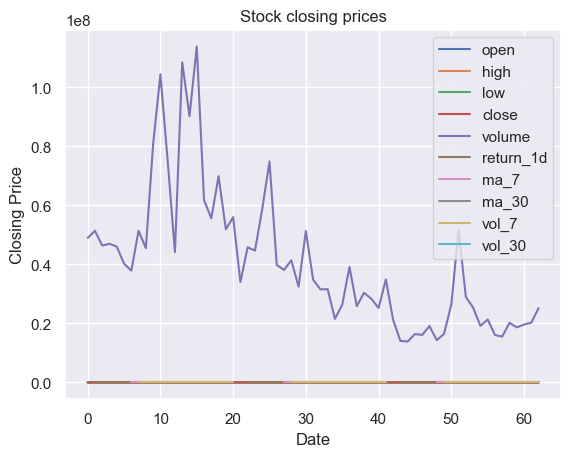

In [20]:
df = df.copy()
#The rolling standard deviation measures the variability (or volatility) 
# of a fixed number of consecutive src/src/src/src/src/src/src/src/src/src/src/src/data points in a time series. 
# It quantifies how much the values deviate from their rolling average.
df["return_1d"] = df.groupby("ticker")["close"].pct_change()
df["ma_7"]  = df.groupby("ticker")["close"].transform(lambda s: s.rolling(7).mean())
df["ma_30"] = df.groupby("ticker")["close"].transform(lambda s: s.rolling(30).mean())
df["vol_7"]  = df.groupby("ticker")["return_1d"].transform(lambda s: s.rolling(7).std())
df["vol_30"] = df.groupby("ticker")["return_1d"].transform(lambda s: s.rolling(30).std())
%pip install matplotlib
import matplotlib.pyplot as plt

# assuming df is your DataFrame and it's already indexed by date
df.plot(grid=True)

plt.legend(loc='best')
plt.title('Stock closing prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


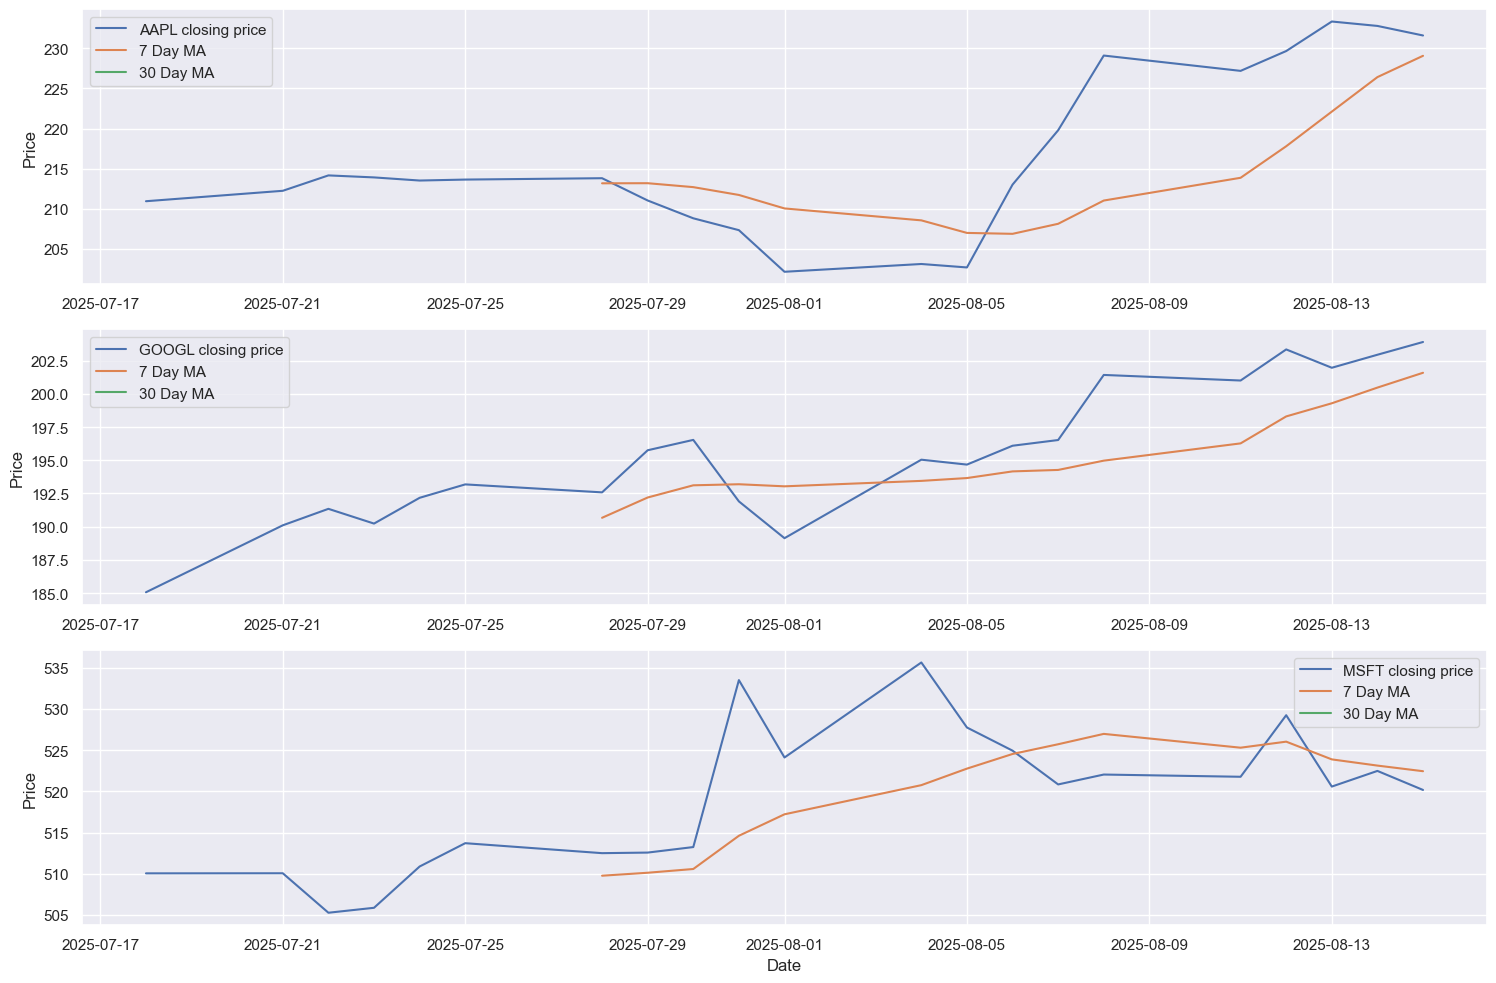

In [23]:
%pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn theme
sns.set_theme()

# create a new figure and set the size.
fig = plt.figure(figsize=(15,10))

# create subplots for each ticker
for i, ticker in enumerate(df["ticker"].unique()):
    ax = fig.add_subplot(len(df["ticker"].unique()), 1, i+1)
    subset = df[df["ticker"] == ticker]
    ax.plot(subset["date"], subset["close"], label=f'{ticker} closing price')
    ax.plot(subset["date"], subset["ma_7"], label='7 Day MA')
    ax.plot(subset["date"], subset["ma_30"], label='30 Day MA')
    ax.legend(loc='best')
    ax.set_ylabel("Price")
    ax.grid(True)

# the xlabel for the last subplot 
ax.set_xlabel("Date")

plt.tight_layout()
plt.show()
fig.savefig('../data/plot.png')

In [ ]:
def compute_rsi(series, n=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(alpha=1/n, min_periods=n, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/n, min_periods=n, adjust=False).mean()

    rs = avg_gain / avg_loss.replace(0, pd.NA)

    rsi = 100 - (100 / (1 + rs))
    return rsi
df["rsi"] = (
    df.groupby("ticker")["close"]
    .apply(lambda group: compute_rsi(group, 14))
    .reset_index(level=0, drop=True)  # Align the index with the original DataFrame
)
df

Price,date,ticker,open,high,low,close,volume,return_1d,ma_7,ma_30,vol_7,vol_30,rsi
0,2025-07-18,AAPL,210.630951,211.549907,209.462280,210.940598,48974600,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-07-21,AAPL,211.859562,215.535383,211.390093,212.239120,51377400,0.006156,NaN,NaN,NaN,NaN,NaN
2,2025-07-22,AAPL,212.898386,214.706331,211.989414,214.156952,46404100,0.009036,NaN,NaN,NaN,NaN,NaN
3,2025-07-23,AAPL,214.756269,214.906093,212.169209,213.907227,46989300,-0.001166,NaN,NaN,NaN,NaN,NaN
4,2025-07-24,AAPL,213.657510,215.445490,213.287935,213.517670,46022600,-0.001821,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,2025-08-11,MSFT,522.299988,527.590027,519.719971,521.770020,20194400,-0.000517,525.298575,NaN,0.013156,NaN,55.374963
59,2025-08-12,MSFT,523.750000,530.979980,522.700012,529.239990,18667000,0.014317,526.031433,NaN,0.012818,NaN,62.104820
60,2025-08-13,MSFT,532.109985,532.700012,519.369995,520.580017,19619200,-0.016363,523.880005,NaN,0.010580,NaN,52.264364
61,2025-08-14,MSFT,522.559998,525.950012,520.140015,522.479980,20269100,0.003650,523.127145,NaN,0.009725,NaN,53.986963


In [37]:
import os
import io
import itertools
import duckdb
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta, timezone

# ---- Config from environment ----
TICKERS = os.getenv("TICKERS", "AAPL,MSFT,TSLA,SPY,QQQ").split(",")
DB_PATH = "../data/market.duckdb"
EXPORT_CSV = "../data/daily_metrics.csv"
LOOKBACK_DAYS = int(os.getenv("LOOKBACK_DAYS", "400"))  # historical backfill
RSI_PERIOD = int(os.getenv("RSI_PERIOD", "14"))

os.makedirs("../data", exist_ok=True)


def fetch_prices(tickers, period_days) -> pd.DataFrame:
    """
    Fetch daily adjusted OHLCV data for the given tickers over the specified period.
    Args:
        tickers (list): List of ticker symbols to fetch data for.
        period_days (int): Number of days to look back from today.

    Returns:
        pd.DataFrame: DataFrame containing date, ticker, open, high, low, close, volume.
    """
    # Fetch daily adjusted OHLCV for the last N days
    start = (
        (datetime.now(timezone.utc) - timedelta(days=period_days)).date().isoformat()
    )
    # .strip() to handle any extra spaces in ticker list
    df = yf.download(
        tickers=[t.strip() for t in tickers],
        start=start,
        interval="1d",
        group_by="ticker",
        threads=True,
        progress=False,
    )
    # Normalize to long format: date, ticker, open, high, low, close, volume
    frames = []
    if isinstance(df.columns, pd.MultiIndex):
        for t in tickers:
            if t.strip() not in df.columns.levels[0]:
                continue
            sub = df[t.strip()].reset_index()
            sub = sub.rename(columns=lambda x: x.lower())
            sub["ticker"] = t.strip()
            frames.append(sub)
    else:
        # Single ticker returns flat columns
        sub = df.reset_index()
        sub = sub.rename(columns=lambda x: x.lower())
        sub["ticker"] = tickers[0].strip()
        frames.append(sub)
    if not frames:
        return pd.DataFrame()
    out = pd.concat(frames, ignore_index=True)
    out = out.rename(columns={"index": "date"})
    out = out.dropna(subset=["close"])
    out["date"] = pd.to_datetime(out["date"]).dt.tz_localize("UTC").dt.date
    cols = ["date", "ticker", "open", "high", "low", "close", "volume"]
    return out[cols].sort_values(["ticker", "date"])


def init_db(con):
    """
    Initialize the DuckDB database with the necessary tables.

    Args:
        con (duckdb.DuckDBPyConnection): DuckDB connection object.
        that will be used to execute SQL commands. Connects to our .duckdb file in
        the DBConnect file.
    """
    # this first table is used to handle the data grabbed from yfinance
    # and cleaned by fetch_prices
    con.execute(
        """
        CREATE TABLE IF NOT EXISTS raw_prices (
            date DATE,
            ticker VARCHAR,
            open DOUBLE, high DOUBLE, low DOUBLE, close DOUBLE,
            volume DOUBLE,
            PRIMARY KEY (date, ticker)
        );
    """
    )
    con.execute(
        """
        CREATE TABLE IF NOT EXISTS daily_metrics (
            date DATE,
            ticker VARCHAR,
            return_1d DOUBLE,
            ma_7 DOUBLE, ma_30 DOUBLE,
            vol_7 DOUBLE, vol_30 DOUBLE,
            rsi DOUBLE,
            PRIMARY KEY (date, ticker)
        );
    """
    )
    con.execute(
        """
        CREATE TABLE IF NOT EXISTS corr_30d (
            date DATE,
            ticker_a VARCHAR,
            ticker_b VARCHAR,
            corr_30d DOUBLE,
            PRIMARY KEY (date, ticker_a, ticker_b)
        );
    """
    )


def upsert_raw_prices(con, prices):
    """
    Upsert daily prices into the raw_prices table.

    Args:
        con (duckdb.DuckDBPyConnection): DuckDB connection object.
        df (pd.DataFrame): DataFrame containing daily prices to upsert.
    """
    if prices.empty:
        return

    # this makes the price table we obtained from yfinance
    # usable within duckdb SQL commands
    # so this says register prices as a table in duckdb
    con.register("prices_df", prices)
    # this inserts everything from the prices_df table
    # into the raw_prices table, replacing any existing rows
    con.execute(
        """
        INSERT OR REPLACE INTO raw_prices
        SELECT * FROM prices_df;
    """
    )
    output_path = "../data/raw_prices_export.csv"
    safe_path = output_path.replace("'", "''")  # escape quotes just in case
    con.execute(f"""
        COPY (
            SELECT *
            FROM raw_prices
            ORDER BY date DESC, ticker
        ) TO '{safe_path}' WITH (HEADER, DELIMITER ',');
    """)
    return len(prices)


def compute_tech(df):
    """
    Compute technical indicators for the given DataFrame.
    Args:
        df (pd.DataFrame): DataFrame containing daily prices with columns:
            date, ticker, open, high, low, close, volume.
            Returns:
        pd.DataFrame: DataFrame with additional columns for technical indicators:
            return_1d, ma_7, ma_30, vol_7, vol
    """
    df = df.copy()
    # The rolling standard deviation measures the variability (or volatility)
    # of a fixed number of consecutive data points in a time series.
    # It quantifies how much the values deviate from their rolling average.
    df["return_1d"] = df.groupby("ticker")["close"].pct_change()
    df["ma_7"] = df.groupby("ticker")["close"].transform(lambda s: s.rolling(7).mean())
    df["ma_30"] = df.groupby("ticker")["close"].transform(
        lambda s: s.rolling(30).mean()
    )
    df["vol_7"] = df.groupby("ticker")["return_1d"].transform(
        lambda s: s.rolling(7).std()
    )
    df["vol_30"] = df.groupby("ticker")["return_1d"].transform(
        lambda s: s.rolling(30).std()
    )

    # Calulcate RSI: RElative Strength Index
    def compute_rsi(series, n=14):
        # has a default value of 1 and sees difference with previous row
        delta = series.diff()
        # .where is used to replace negative values with 0
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        avg_gain = gain.ewm(alpha=1 / n, min_periods=n, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1 / n, min_periods=n, adjust=False).mean()

        rs = avg_gain / avg_loss.replace(0, pd.NA)
        rsi = 100 - (100 / (1 + rs))
        return rsi

    df["rsi"] = (
        df.groupby("ticker")["close"]
        .apply(lambda group: compute_rsi(group, 14))
        .reset_index(level=0, drop=True)  # Align the index with the original DataFrame
    )
    return df


def upsert_metrics(con, metrics):
    """
    Upsert daily metrics into the daily_metrics table.

    Args:
        con (duckdb.DuckDBPyConnection): DuckDB connection object.
        df (pd.DataFrame): DataFrame containing daily metrics to upsert.
    """
    if metrics.empty:
        return 0

    # Register the DataFrame as a DuckDB table
    cols = ["date", "ticker", "return_1d", "ma_7", "ma_30", "vol_7", "vol_30", "rsi"]
    con.register("metrics_df", metrics[cols])
    con.execute("INSERT OR REPLACE INTO daily_metrics SELECT * FROM metrics_df;")

    con.execute(f"""
        COPY (
            SELECT *
            FROM daily_metrics
            WHERE date >= current_date - INTERVAL 120 DAY
            ORDER BY date DESC, ticker
        ) TO '{EXPORT_CSV}' WITH (HEADER, DELIMITER ',');
    """)

    return len(metrics)


In [35]:
prices = fetch_prices(TICKERS, LOOKBACK_DAYS)
metrics = compute_tech(prices)
con = duckdb.connect(DB_PATH)
init_db(con)
n_metrics = upsert_metrics(con, metrics)
upsert_raw_prices(con, prices)

/var/folders/l3/07r79w4x3znd84b94h4223m80000gn/T/ipykernel_31908/3221149479.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


2735

In [26]:
import pipeline


In [27]:
df = fetch_prices(TICKERS, LOOKBACK_DAYS)

/var/folders/l3/07r79w4x3znd84b94h4223m80000gn/T/ipykernel_31908/1124278083.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
